In [1]:
import matplotlib.pyplot as plt
import numpy as np

from bluepysnap import Simulation
from bluepysnap.bbp import Cell

In [2]:
# Get the simulation
sim = Simulation("/gpfs/bbp.cscs.ch/project/proj42/circuits/CA1.O1/mooc-circuit/simulation_config.json")

In [3]:
# Get the global spikes report and the specific hippocampus one
spikes = sim.spikes
hippocampus_spikes = spikes["hippocampus_neurons"]

In [4]:
# get the hippocampus neurons which spiked and check the properties of the spiking neurons
hippocampus_spikes.nodes.get(group=hippocampus_spikes.node_ids).head()

,etype,layer,model_template,model_type,morph_class,morphology,mtype,region,rotation_angle_xaxis,rotation_angle_yaxis,rotation_angle_zaxis,synapse_class,x,y,z,@dynamics:holding_current,@dynamics:threshold_current
145,cACpyr,SP,hoc:CA1_pyr_cACpyr_oh140807_A0_idB_2019030510521,biophysical,PYR,dend-mpg141216_A_idA_axon-mpg141017_a1-2_idC_-...,SP_PC,mc0;SP,3.141593,-1.256615,3.141593,EXC,475.613040,214.946340,418.594196,-0.116927,0.263672
277,cACpyr,SP,hoc:CA1_pyr_cACpyr_mpg141217_A_idB_2019030511280,biophysical,PYR,dend-mpg141216_A_idA_axon-mpg141017_a1-2_idC_-...,SP_PC,mc4;SP,0.000000,-0.582821,0.000000,EXC,102.885407,205.698670,820.509814,-0.121854,0.283203
427,cACpyr,SP,hoc:CA1_pyr_cACpyr_mpg141217_A_idB_2019030511280,biophysical,PYR,dend-mpg141216_A_idA_axon-mpg141017_a1-2_idC,SP_PC,mc4;SP,-3.141593,0.308174,-3.141593,EXC,151.772716,170.433333,808.895026,-0.126112,0.283203
602,cACpyr,SP,hoc:CA1_pyr_cACpyr_mpg141217_A_idB_2019030511280,biophysical,PYR,dend-mpg141216_A_idA_axon-mpg141017_a1-2_idC_-...,SP_PC,mc2;SP,-3.141593,-0.927936,-3.141593,EXC,175.807845,215.114387,620.637111,-0.121854,0.283203
669,cACpyr,SP,hoc:CA1_pyr_cACpyr_mpg141217_A_idB_2019030511280,biophysical,PYR,dend-mpg141216_A_idA_axon-mpg141017_a1-2_idC_-...,SP_PC,mc6;SP,3.141593,-1.197367,3.141593,EXC,569.932009,173.500045,760.627625,-0.121668,0.278320


In [5]:
# filter the report on SP_PC cells from the mc2 column only
# @armando I changed SP_BS to SP_PC because there were no SP_BS spiking
filtered_spikes = spikes.filter(group={Cell.MTYPE: 'SP_PC', 'region': {'$regex': "mc2.*"}})

In [6]:
filtered_spikes.report.head()

,ids,population
times,,
0.850,11998,hippocampus_neurons
3.075,2715,hippocampus_neurons
3.150,602,hippocampus_neurons
3.150,3311,hippocampus_neurons
3.150,13362,hippocampus_neurons


In [7]:
# Hack : cell we need to remove with a better simulation
times = filtered_spikes.report.index.values
filtered_spikes.report.loc[times.max() + 0.15] = [3311, "hippocampus_neurons"]
times = filtered_spikes.report.index.values
filtered_spikes.report.loc[times.max() + 0.15] = [602, "hippocampus_neurons"]

In [8]:
# Spiking neurons and number of spikes per neurons during the simulation for the filtered cells
node_ids, nb_spikes = np.unique(filtered_spikes.report["ids"], return_counts=True)

In [9]:
# get full set of properties for neurons which spikes more than once 
hippocampus_spikes.nodes.get(group=node_ids[nb_spikes > 1])

,etype,layer,model_template,model_type,morph_class,morphology,mtype,region,rotation_angle_xaxis,rotation_angle_yaxis,rotation_angle_zaxis,synapse_class,x,y,z,@dynamics:holding_current,@dynamics:threshold_current
602,cACpyr,SP,hoc:CA1_pyr_cACpyr_mpg141217_A_idB_2019030511280,biophysical,PYR,dend-mpg141216_A_idA_axon-mpg141017_a1-2_idC_-...,SP_PC,mc2;SP,-3.141593,-0.927936,-3.141593,EXC,175.807845,215.114387,620.637111,-0.121854,0.283203
3311,cACpyr,SP,hoc:CA1_pyr_cACpyr_mpg141217_A_idB_2019030511280,biophysical,PYR,dend-mpg141216_A_idA_axon-mpg141017_a1-2_idC_-...,SP_PC,mc2;SP,0.000000,-0.839371,0.000000,EXC,478.186235,187.794660,703.596068,-0.121854,0.283203


In [10]:
# get full set of  properties for neurons which spikes only once
hippocampus_spikes.nodes.get(group=node_ids[nb_spikes == 1]).head()

,etype,layer,model_template,model_type,morph_class,morphology,mtype,region,rotation_angle_xaxis,rotation_angle_yaxis,rotation_angle_zaxis,synapse_class,x,y,z,@dynamics:holding_current,@dynamics:threshold_current
1714,cACpyr,SP,hoc:CA1_pyr_cACpyr_mpg141217_A_idB_2019030511280,biophysical,PYR,dend-mpg141216_A_idA_axon-mpg141017_a1-2_idC_-...,SP_PC,mc2;SP,-3.141593,1.039324,-3.141593,EXC,490.933421,203.071957,597.541707,-0.119277,0.273438
2715,cACpyr,SP,hoc:CA1_pyr_cACpyr_mpg141217_A_idB_2019030511280,biophysical,PYR,dend-051208AM2_axon-mpg141017_a1-2_idC_-_Scale...,SP_PC,mc2;SP,-3.141593,1.030332,-3.141593,EXC,175.621672,183.419388,554.138482,-0.083050,0.234375
4011,cACpyr,SP,hoc:CA1_pyr_cACpyr_mpg141217_A_idB_2019030511280,biophysical,PYR,dend-mpg141216_A_idA_axon-mpg141017_a1-2_idC_-...,SP_PC,mc2;SP,-3.141593,-0.346358,-3.141593,EXC,494.910757,199.681410,787.182700,-0.119009,0.278320
4206,cACpyr,SP,hoc:CA1_pyr_cACpyr_mpg141217_A_idB_2019030511280,biophysical,PYR,dend-mpg150305_A_idB_axon-mpg141017_a1-2_idC_-...,SP_PC,mc2;SP,0.000000,-0.196576,0.000000,EXC,379.640730,226.106078,574.972647,-0.201783,0.390625
4770,cACpyr,SP,hoc:CA1_pyr_cACpyr_mpg141217_A_idB_2019030511280,biophysical,PYR,dend-mpg141216_A_idA_axon-mpg141017_a1-2_idC_-...,SP_PC,mc2;SP,3.141593,-1.113728,3.141593,EXC,393.798331,178.901977,423.565259,-0.119009,0.278320


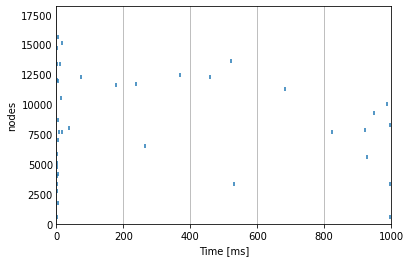

In [11]:
# raster
filtered_spikes.raster() ;

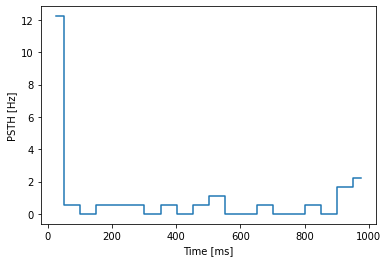

In [12]:
# PSTH
filtered_spikes.firing_rate_histogram() ;

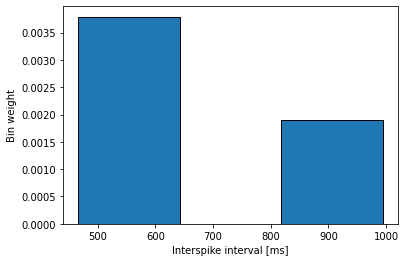

In [13]:
# ISI distribution
filtered_spikes.isi() ;

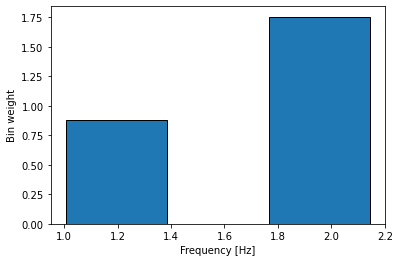

In [14]:
# ISI frequency distribution 
filtered_spikes.isi(use_frequency=True) ;

In [15]:
# get mean frequencies for each neuron from the report
def get_mean_frequencies():
    gb = filtered_spikes.report.groupby(["ids", "population"])
    res = []
    for _, node_spikes in gb:
        time_differences = np.diff(node_spikes.index.to_numpy())
        if len(time_differences) != 0:
            res.append(1000/time_differences.mean())
    return np.asarray(res)

In [16]:
def plot_spike_frequency(mean_frequencies, ax=None):
    
    if ax is None:
        ax = plt.gca()
        ax.set_xlabel('Frequency [Hz]')
        ax.set_ylabel('# neurons')

    fig = plt.gcf()
    
    mean = mean_frequencies.mean()
    ax.hist(mean_frequencies)
    ax.axvline(x=mean, color='red')
    
    text = f'{mean:2.8f}'
    limits =  ax.get_xlim()
    mean_text_pos = (limits[1] - mean)/(limits[1] - limits[0]) + 0.05
    
    fig.text(mean_text_pos, 0.80, text, color='red', fontsize=12)
    
    return ax

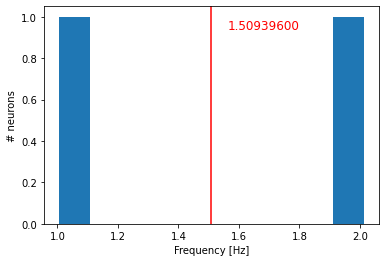

In [17]:
plot_spike_frequency(get_mean_frequencies())

In [18]:
from IPython.display import HTML
anim, ax = filtered_spikes.firing_animation()
plt.close() # need this to avoid the first frame to appear in a notebook
HTML(anim.to_html5_video())

In [19]:
# show the different available reports for this simulation
print(sim.reports)

{'soma_report': <bluepysnap.frame_report.SomaReport object at 0x7f7ec72e0860>}


In [20]:
# reports can be massive we select just few node_ids
hippocampus_soma_report = sim.reports["soma_report"]["hippocampus_neurons"]
node_ids = hippocampus_soma_report.nodes.ids(group={Cell.MTYPE: 'SP_PC', 'region': {'$regex': "mc2.*"}}, sample=15)

In [21]:
filtered_report_soma = sim.reports["soma_report"].filter(group=node_ids)
filtered_report_soma.report.head()

hippocampus_neurons                                              \
                  44         267        4241       4592       6124    
0.0          -62.730404 -61.270809 -61.505894 -61.327732 -70.879417   
0.1          -63.157013 -61.739922 -62.132401 -61.793716 -70.598862   
0.2          -63.499001 -62.065647 -62.508759 -62.105289 -70.429749   
0.3          -63.782078 -62.325500 -62.797264 -62.348682 -70.316063   
0.4          -64.027199 -62.549744 -63.042355 -62.556583 -70.231583   

                                                                       \
         6963       9331       10344      10512      11468      12963   
0.0 -68.844101 -61.417763 -63.705723 -61.301338 -62.754700 -64.773178   
0.1 -68.832878 -61.905460 -63.884144 -61.670368 -63.024582 -64.932281   
0.2 -68.824615 -62.235809 -64.014824 -61.912666 -63.201763 -65.042595   
0.3 -68.817772 -62.494492 -64.127350 -62.097637 -63.335384 -65.133484   
0.4 -68.811546 -62.716778 -64.231064 -62.256397 -63.448360 -65.214386   

                                                 
         13151      15822      16192      16825  
0.0 -61.396503 -61.629345 -61.599068 -66.597855  
0.1 -61.639862 -61.917816 -62.033356 -66.679482  
0.2 -61.811783 -62.113113 -62.350372 -66.738480  
0.3 -61.958721 -62.265949 -62.604664 -66.787994  
0.4 -62.094891 -62.399273 -62.822765 -66.832695

In [22]:
def multi_traces(nids):
    etypes = hippocampus_soma_report.nodes.get(node_ids, Cell.ETYPE)
    fig, axs = plt.subplots(nrows=nids, sharex=True, sharey=False, figsize=(6, 1.5 * nids))
    for ax, node_id, etype in zip(axs, node_ids[:nids], etypes):
        ax.ticklabel_format(useOffset=False, style='plain')
        ax.set_ylabel("%d\n%s" % (node_id, etype))
        cdata = filtered_report_soma.report.loc[:, ("hippocampus_neurons", node_id)]
        ax.plot(np.array(cdata.index), cdata.values)
        ax.yaxis.set_label_position("right")
        ax.set_ylabel("a%d\n%s" % (node_id, etype))
        ax.grid()
    axs[-1].set_xlabel('Time [ms]')
    fig.text(0.02, 0.5, 'Voltage [mV]', va='center', rotation='vertical')

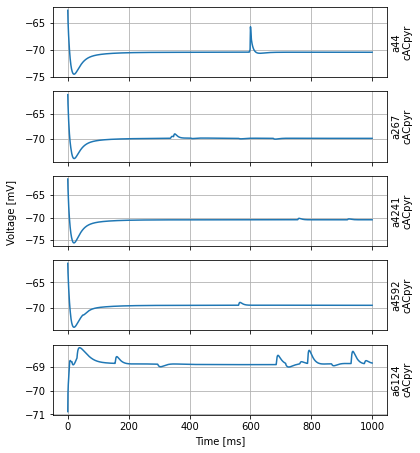

In [23]:
multi_traces(5)

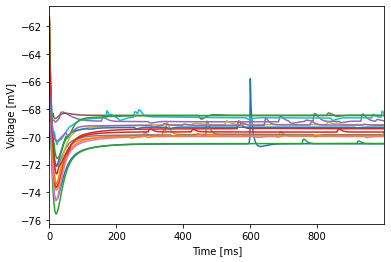

In [24]:
# sample traces
filtered_report_soma.trace(plot_type="all") ;

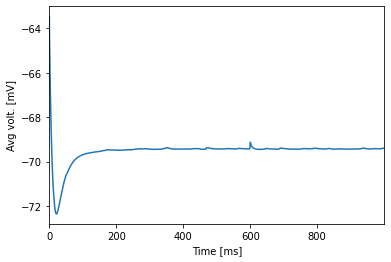

In [25]:
# sample traces mean
filtered_report_soma.trace(plot_type="mean") ;